In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib
from sklearn.preprocessing import StandardScaler
from dateutil import relativedelta

In [3]:
df = pd.read_csv("eshop.csv")

In [4]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


RECENCY (R): Time since last purchase
FREQUENCY (F): Total number of purchases
MONETARY VALUE (M): Total monetary valueCLAY

In [5]:
df_group = df.groupby('Customer ID').agg({'Date': lambda x: x.max(), # Recency
                                        'Customer ID': lambda x: len(x),# Frequency
                                        'Subtotal': lambda x: x.sum()}) 
df_group.rename(index=str, columns={"Date": "Recency", "Customer ID": "Frequency", "Subtotal": "Total"}, inplace= True)

Date conversion. I subtract the last date so we could work with the data as with "fresh".

In [6]:
df_group['Recency'] = pd.to_datetime(df_group['Recency'],infer_datetime_format=True)
df_group['Recency'] = df_group['Recency'].apply(lambda x: (datetime.today() - x).days)
min_date = df_group['Recency'].min()
df_group['Recency'] = df_group['Recency'].apply(lambda x: x-min_date+1)

Let's normalize the data using StandardScaler.

In [7]:
scaler = StandardScaler()
scaler.fit(df_group)
df_normalized = scaler.transform(df_group)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Applying K Means algorithm with a different number of clusters.

In [8]:
k = 10
ssd = []
n_iter = []
for i in range(1,k):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_normalized)
    # inertia_ - sum of squared distances of samples to their closest cluster center.
    ssd.append(kmeans.inertia_)
    # n_iter_ - number of iterations run.
    n_iter.append(kmeans.n_iter_)

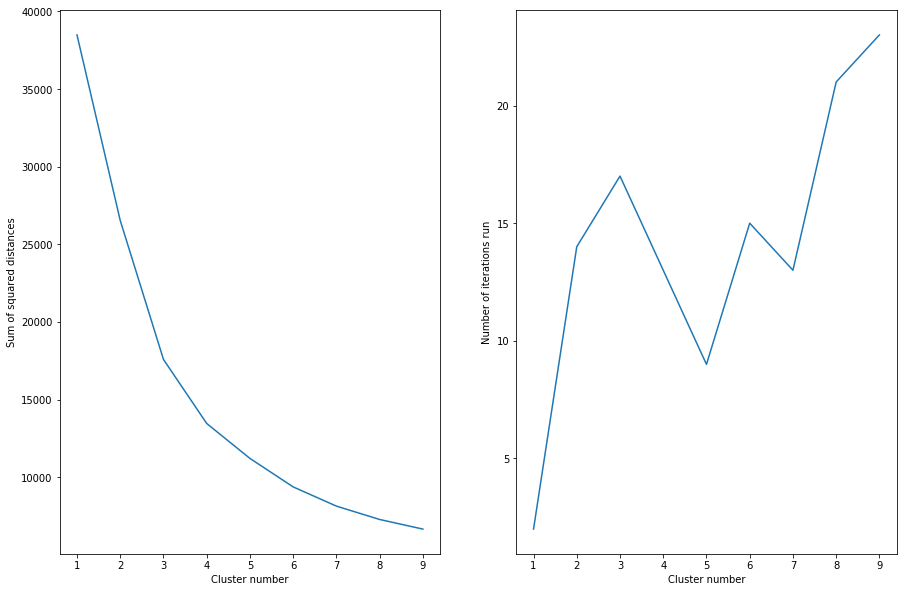

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(range(1,k), ssd)
plt.xlabel('Cluster number')
plt.ylabel('Sum of squared distances')
plt.subplot(122)
plt.plot(range(1,k), n_iter)
plt.xlabel('Cluster number')
plt.ylabel('Number of iterations run')
plt.show()

As can be seen from the graphs the optimal number of clusters: 5

In [10]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(df_normalized)
df_group['clusters'] = clusters
df_group.groupby('clusters').agg(['median', 'count'])

Total       Recency       Frequency      
            median count  median count    median count
clusters                                              
0           54.240  5604    1783  5604       1.0  5604
1           61.250  6215     580  6215       1.0  6215
2          510.100   847     962   847       5.0   847
3         7322.305    12     683    12       9.5    12
4         1637.950   151     844   151      13.0   151

The most interesting customer cluster is number 3. These are customers who often make orders and for very large sums. Also interesting is cluster 4 because it contains customers with a high frequency of orders. Customers who recently made a single order and can be attributed to the "new customers" got into cluster 1. In cluster 0 there are customers who made a single order for a long time.

The most interesting groups:
- 3 - the most profitable clients
- 4 - regular customers
- 1 - fresh customers

Let's try another method. For work we will use data only for the last year. We will also consider how many months have passed since the last purchase and the maximum purchase price.

In [11]:
# data preprocessing
df = pd.read_csv("eshop.csv")
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df['days'] = df['Date'].apply(lambda x: (datetime.today() - x).days)
min_date = df['days'].min()
df['days'] = df['days'].apply(lambda x: x-min_date+1)
df_last_year = df[df['days'] <= 365]
last_data = df_last_year['Date'].max()
df_last_year['month'] = df_last_year['Date'].apply(lambda x: relativedelta.relativedelta(last_data,x).months+1)
df_last_year.drop(['Date', 'Country'], axis = 1, inplace= True)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
#group data and rename features
df_group = df_last_year.groupby('Customer ID').agg({'month': lambda x: x.min(),
                                        'Customer ID': lambda x: len(x),
                                        'Subtotal': lambda x: x.max()})  
df_group.rename(index=str, columns={"month": "Month", "Customer ID": "Count", "Subtotal": "Max"}, inplace= True)

In [13]:
#normalize data
scaler = StandardScaler()
scaler.fit(df_group)
df_normalized = scaler.transform(df_group)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [14]:
# KMeans alg.
k = 10
ssd = []
n_iter = []
for i in range(1,k):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_normalized)
    # inertia_ - sum of squared distances of samples to their closest cluster center.
    ssd.append(kmeans.inertia_)
    # n_iter_ - number of iterations run.
    n_iter.append(kmeans.n_iter_)

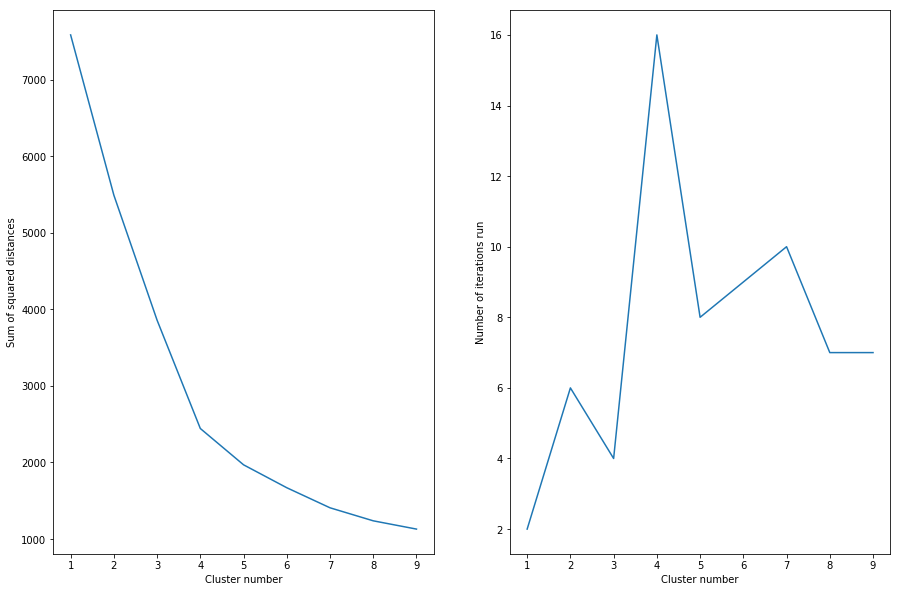

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(range(1,k), ssd)
plt.xlabel('Cluster number')
plt.ylabel('Sum of squared distances')
plt.subplot(122)
plt.plot(range(1,k), n_iter)
plt.xlabel('Cluster number')
plt.ylabel('Number of iterations run')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(df_normalized)
df_group['clusters'] = clusters

In [17]:
df_group.groupby('clusters').agg(['median', 'count'])

Month             Max        Count      
         median count    median count median count
clusters                                          
0           9.0  1021    53.110  1021    1.0  1021
1           2.5   220   143.765   220    3.0   220
2           3.0  1247    56.950  1247    1.0  1247
3           1.0    39   232.490    39    7.0    39
4          10.0     2  6795.810     2    1.5     2

- Cluster 0 - Customers who rarely placed orders a long time ago
- Cluster 1 - "New" customers who have already made several orders
- Cluster 2 - Customers who rarely placed orders, but recently
- Cluster 3 - Customers who place orders regularly
- Cluster 4 - Customers who have made very large orders

The most interesting clients are in cluster 3 (regular customers),  cluster 4 (big profit) and I think in the cluster 1, as potential regular customers
